# Optimizing Financial Aid Resources

**Notebook by [Dev Nambi](https://blogs.uw.edu/fractals/)**


### Goals

This notebook uses the enrollment prediction model created elsewhere and optimizes the distribution of funds given the constraints involved (total scholarship funding, explainability).


### Process

* A. Define constraints, such as the average SAT score, or average high school GPA, the different scholarship values, and the number of students to admit.
* B. Load in student data, software libraries, and model objects.
* C. Pass 1 - Arbitrary Predictions
* D. Calculate and visualize yield, net revenue, and scholarship info per segment.
* E. Pass 2 - Transfer Learning
* F. Calculate and visualize yield, net revenue, and scholarship info in an explainable way.
* G. Save off the results for later use.


### Resources

* https://github.com/rhiever/Data-Analysis-and-Machine-Learning-Projects/blob/master/pareto-optimized-road-trip/optimized-state-capitols-trip.ipynb

## Part A - Define Goals and Constraints

Next we're going to have to specify constraints we care about:

* **Maximum Student Enrollment** - The maximum number of domestic non-resident students you would like to enroll
* **Average Student SAT** - The minimum average SAT for domestic non-resident students you're willing to accept
* **Award Amounts** - The different scholarship amounts to award.
* **Scholarship Fund Amount** - The amount of money to distribute via Purple and Gold scholarships

#### First, Define Constraints

In [22]:
fund_amount = 3000000   #3 million dollars

maximum_student_enrollment = 2100

average_student_sat = 1090

tuition_amount = 34143

#scholarship_amounts = [0,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
scholarship_amounts = [0,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
#scholarship_amounts = [0,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000]
max_scholarship = max(scholarship_amounts)

number_of_buckets = 20

cutoff_threshold = 0.5

## Part B - Load in student data, software libraries, and model objects

### Part B1 - Load software libraries

In [23]:
# Load in software libraries
import os
import sys
import pandas as pd
import numpy as np
import pickle
import random
import copy
from tqdm import tqdm

# Get data-munging libraries
from sklearn import preprocessing
from sklearn import decomposition

# Get ML libraries
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier

# Get Viz libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Genetic algorithm
from deap import algorithms
from deap import base
from deap import creator
from deap import tools

### Part B2 - Load  objects

In [37]:
model_location = 'boosting_model.pkl'

with open(model_location, 'rb') as model_input:
    predict_model = pickle.load(model_input)

#print (str(predict_model))

df = pd.read_csv('Transformed_Data_set_v3.csv')

propensity_df = pd.read_csv('Propensity_and_Tuition.csv')

In [38]:
propensity_df.head()

MinScore  MaxScore  TuitionEffect
0     0.000     0.068        0.00644
1     0.068     0.083        0.00600
2     0.083     0.095        0.00600
3     0.095     0.100        0.00600
4     0.100     0.104        0.00600

### Part C - First Pass, Arbitrary Predictions

1. Get the data into a handy format
2. Add propensity scores
3. Predict students who will come with no PuGo
4. For each scholarship amount, predict students who will switch and attend

**Reminder Constraints**

fund_amount
average_student_sat
award_amounts
maximum_student_enrollment

*Coding Notes*

* df_2 is used for predictions (remove IsEnrolledOrMatriculated)
* df_3 has the results we use, the scholarship amounts

In [39]:
drop_all_nulls = True

if drop_all_nulls:
    cols = df.columns[df.isnull().any()]
    df_hold = df.loc[(~df[cols].isnull().any(axis = 1))]

In [40]:
df.shape

(53610, 81)

In [41]:
df_hold.shape

(53610, 81)

In [42]:
df_IsEnrolled = df_hold.IsEnrolledOrMatriculated
df_2 = df_hold.copy(deep=True)
df_2.drop('IsEnrolledOrMatriculated', axis=1, inplace=True)

In [43]:
df_3 = df_hold.copy(deep=True)
#df_3 = pd.DataFrame(model_scalar.inverse_transform(df_2), columns=df_2.columns)
#df_3['IsEnrolledOrMatriculated'] = df_IsEnrolled
#df_3.describe()

In [44]:
df_3['PuGo_Amount'] = 0
df_3['EnrollPrediction'] = 0
df_3['EnrollPredictionTemp'] = 0
df_3['OriginalTuition_After_Grants'] = df_3['tuition_after_grants']

In [45]:
df_3.tuition_after_grants.describe()

count    53610.000000
mean         0.106279
std          0.558558
min         -4.977979
25%         -0.366968
50%          0.000000
75%          0.633032
max          0.739523
Name: tuition_after_grants, dtype: float64

In [46]:
df_3.columns

Index([u'IsEnrolledOrMatriculated', u'yr_matched', u'EFC', u'Fisap_Income',
       u'WorkLoans', u'TuitionRemaining', u'TotalBudgetRemaining',
       u'HighSchoolGPA', u'TestScore', u'AcademicScore', u'HolisticScore1',
       u'HolisticScore2', u'UWAttraction_TotalCount', u'UWAttraction_TotalPct',
       u'UWAttraction_ProdPct', u'UWLocationAttraction_TotalCount',
       u'UWLocationAttraction_TotalPct', u'UWEdGoals_TotalCount',
       u'UWEdGoals_TotalPct', u'UWEdGoals_ProdPct', u'LowerIncomePct',
       u'LowerIncomeCount', u'HigherIncomeCount', u'LowerParentEdPct',
       u'LowerParentEdCount', u'HigherParentEdCount',
       u'CollegeLocationPct_BorderState', u'FamilyIncomePct_140to200K',
       u'FirstGenerationPct_Not1stGen', u'ParentEducationPct_NoResponse',
       u'BioAndMed', u'CompSci', u'Eng', u'Business', u'PsychAnthro',
       u'Nursing', u'Com', u'English', u'IntlStudies', u'Math', u'PhysicsAstr',
       u'Environ', u'Law', u'ArtDesign', u'DeltaParentEdMinusAcademic',
   

In [47]:
def get_tuition_effect(prediction_score):
    tuition_score = propensity_df.TuitionEffect[(prediction_score >= propensity_df.MinScore) & (prediction_score < propensity_df.MaxScore)].head(1)
    return tuition_score

In [48]:
# test the function
get_tuition_effect(0.34596)

17    0.00742
Name: TuitionEffect, dtype: float64

### Part C1 - Predict which students will attend with no PuGo scholarship

In [49]:
# df_2.ix[:,0:31] <- use this to ignore columns added at the end
df_3['PredictionScore'] = predict_model.predict_proba(df_2)[:, 1]
df_3['EnrollPredictionTemp'] = predict_model.predict(df_2)

#df_3.describe()

In [50]:
df_3['TuitionEffect'] = df_3.apply(lambda row: float(get_tuition_effect(row['PredictionScore'])), axis=1)
df_3.loc[df_3.TuitionEffect < 0, 'TuitionEffect'] = 0

In [51]:
df_3.TuitionEffect.describe()

count    53610.000000
mean         0.009549
std          0.005681
min          0.006000
25%          0.006000
50%          0.006440
75%          0.007420
max          0.019390
Name: TuitionEffect, dtype: float64

In [52]:
df_3['EnrollPrediction'] = df_3['EnrollPredictionTemp']

In [53]:
print ('Students who will enroll with no PuGo funding:',df_3.EnrollPrediction.sum())

('Students who will enroll with no PuGo funding:', 14188L)


## Part D - Calculate and visualize yield, net revenue, and scholarship info per segment.

In [54]:
predicted_pugo_offered = df_3.PuGo_Amount.sum()
print 'PuGo Offered: ' + str(predicted_pugo_offered)

predicted_pugo_use = df_3.PuGo_Amount[df_3['EnrollPrediction'] == 1].sum()
print 'PuGo Use: ' + str(predicted_pugo_use)

PuGo Offered: 0
PuGo Use: 0


In [55]:
predicted_student_count = df_3.EnrollPrediction.sum()
total_student_count = df_3.EnrollPrediction.count()

print 'Predicted students: ' + str(predicted_student_count)
print 'Admitted students: ' + str(total_student_count)
print 'Predicted yield: ' + str(predicted_student_count * 100.0 / total_student_count)

Predicted students: 14188
Admitted students: 53610
Predicted yield: 26.4652117142


In [56]:
predicted_net_revenue = df_3.tuition_after_grants[df_3['EnrollPrediction'] == 1].sum()
print 'Predicted Net Revenue: ' + str(predicted_net_revenue)

Predicted Net Revenue: -4714.21594084


In [57]:
predicted_avg_sat = df_3.TestScore[df_3['EnrollPrediction'] == 1].mean()
print 'Predicted Average SAT: ' + str(predicted_avg_sat)

Predicted Average SAT: -0.0869163540153


## Part E - Pass 2, Transfer Learning and Genetic Optimization

* Useful resources, https://github.com/DEAP/notebooks/blob/master/OneMax.ipynb
* https://github.com/DEAP/notebooks/blob/master/SIGEvolution.ipynb
* http://deap.readthedocs.io/en/master/tutorials/basic/part1.html

### E1 - Assign students to 'buckets' based on academic performance

* Assign each student to a bucket
* Analyze and report on the characteristics of each bucket

In [58]:
df_3['BucketRank'] = df_3['AcademicScore'].rank(ascending=1)

bucket_count = 20
rows_per_bucket = df_3.BucketRank.count() / bucket_count

df_3['Bucket'] = np.floor(df_3['BucketRank'] / rows_per_bucket)

In [59]:
for i in range(0,20):
    high_school_gpa = df_3.HighSchoolGPA[df_3['Bucket'] == i].sum()
    min_high_school_gpa = df_3.HighSchoolGPA[df_3['Bucket'] == i].quantile(0.2)
    max_high_school_gpa = df_3.HighSchoolGPA[df_3['Bucket'] == i].quantile(0.8)
    test_score = df_3.TestScore[df_3['Bucket'] == i].sum()
    min_test_score = df_3.TestScore[df_3['Bucket'] == i].quantile(0.2)
    max_test_score = df_3.TestScore[df_3['Bucket'] == i].quantile(0.8)
    academic_score = df_3.AcademicScore[df_3['Bucket'] == i].sum()
    holistic_1 = df_3.HolisticScore1[df_3['Bucket'] == i].quantile(0.99)
    holistic_2 = df_3.HolisticScore1[df_3['Bucket'] == i].quantile(0.99)
    efc = df_3.EFC[df_3['Bucket'] == i].sum()
    students = df_3.HighSchoolGPA[df_3['Bucket'] == i].count()
    
    printString = ['bucket: ', str(i), '; students: ', str(students), '; hs GPA: ', str(high_school_gpa*1.0/students), 
     ' - ', str(min_high_school_gpa), '/', str(max_high_school_gpa), '; tests: ', str(test_score*1.0/students),
     ' - ', str(min_test_score), '/', str(max_test_score), '; \n\tscores: ', str(academic_score*1.0 / students),
     ' - ', str(efc*1.0/students), '/', str(holistic_1), '/', str(holistic_2)]
    print  ''.join(printString)



#df_3[df_3['Bucket'] == i].columns

bucket: 0; students: 2681; hs GPA: -2.72335062674 - -3.0303030303/-1.90909090909; tests: -1.48458764908 - -2.10256410256/-0.358974358974; 
	scores: -2.83367841574 - 0.0440352644209/1.62500028125/1.62500028125
bucket: 1; students: 2678; hs GPA: -1.42511372123 - -1.69696969697/-1.24242424242; tests: -0.923277991613 - -1.4358974359/0.0; 
	scores: -1.51648631269 - 0.192012745704/1.62500028125/1.62500028125
bucket: 2; students: 2681; hs GPA: -1.05467204684 - -1.27272727273/-0.909090909091; tests: -0.562189768456 - -1.07692307692/0.205128205128; 
	scores: -1.09287488324 - 0.257742706508/1.63750030938/1.63750030938
bucket: 3; students: 2680; hs GPA: -0.810820895523 - -1.0/-0.666666666667; tests: -0.377774588595 - -0.871794871795/0.307692307692; 
	scores: -0.826688429045 - 0.291530693727/1.62500028125/1.62500028125
bucket: 4; students: 2676; hs GPA: -0.640066585134 - -0.787878787879/-0.484848484848; tests: -0.257234295351 - -0.820512820513/0.333333333333; 
	scores: -0.642337049907 - 0.36798955

**Make a single function that evaluates a scholarship 'bucket list' and returns relevant metrics**

Note: this is the most important bit of code in this entire notebook.

The function returns:

   * net tuition revenue
   * scholarship amount
   * students enrolled
   * median test score
   * yield 

In [60]:
def parse_scholarships_base(buckets, include_bucket_counts):
    """
        This function returns the net tuition revenue, scholarship used, 
        student count, and average test score
    """
    tuition_revenue = 0
    scholarship_used = 0
    students = 0
    total_test_score = 0
    
    buckets = list(buckets)
    
    for i in range(len(buckets)):
        bucket_amount = buckets[i]
        #df_3.PuGo_Amount[df_3['Bucket'] == i] = bucket_amount
        #df_3.PuGo_Amount[] = bucket_amount
        df_3.loc[df_3.Bucket == i, 'PuGo_Amount'] = bucket_amount
    #
    #
    #
    #df_3['tuition_after_grants'] = df_3['OriginalTuition_After_Grants'] - df_3['PuGo_Amount']
    df_3['PredictionScoreTemp'] = df_3['PredictionScore'] + df_3['TuitionEffect']*df_3['PuGo_Amount']
    #
    df_3.loc[df_3.PredictionScoreTemp >= cutoff_threshold, 'EnrollPredictionTemp'] = 1
    df_3.loc[df_3.PredictionScoreTemp < cutoff_threshold, 'EnrollPredictionTemp'] = 0
    #
    students = df_3.EnrollPredictionTemp[df_3['EnrollPredictionTemp'] == 1].count()
    student_grads = df_3['5yr_grad_rate'][df_3['EnrollPredictionTemp'] == 1].sum()
    scholarship_used = df_3.PuGo_Amount[df_3['EnrollPredictionTemp'] == 1].sum()
    #tuition_revenue =  students * tuition_amount
    tuition_revenue =  (tuition_amount * df_3['5yr_grad_rate'] * df_3['EnrollPredictionTemp']).sum()
    total_test_score = df_3.TestScore[df_3['EnrollPredictionTemp'] == 1].sum()
    total_students = df_3.EnrollPredictionTemp.count()
    
    if include_bucket_counts:
        # look at the information per bucket
        for i in range(len(buckets)):
            bucket_students = df_3.EnrollPredictionTemp[(df_3['EnrollPredictionTemp'] == 1) & (df_3['Bucket'] == i)].count()
            #bucket_student_grads = df_3['5yr_grad_rate'][df_3['EnrollPredictionTemp'] == 1 & (df_3['Bucket'] == i)].sum()
            bucket_scholarship_used = df_3.PuGo_Amount[(df_3['EnrollPredictionTemp'] == 1) & (df_3['Bucket'] == i)].sum()
            bucket_revenue = bucket_students * tuition_amount
            bucket_test_score = df_3.TestScore[(df_3['EnrollPredictionTemp'] == 1) & (df_3['Bucket'] == i)].sum()
            bucket_total_students = df_3.EnrollPredictionTemp[df_3['Bucket'] == i].count()
            
            printString = ''.join(['Bucket: ', str(i), '; students: ', str(bucket_students), '; scholarships: ', 
                                  str(bucket_scholarship_used), '; gross: ', str(bucket_revenue - bucket_scholarship_used),
                                  '; test score: ', str(bucket_test_score * 1.0 / bucket_students * 1.0), 
                                  '; student %age: ', str(bucket_students * 1.0 / bucket_total_students)])
            
            print printString
            #print ('Bucket ',i, bucket_students, bucket_scholarship_used, bucket_revenue - bucket_scholarship_used, bucket_test_score * 1.0 / bucket_students * 1.0, bucket_students * 1.0 / bucket_total_students)
        
    # return everything
    return tuition_revenue - scholarship_used, scholarship_used, students, total_test_score * 1.0 / students * 1.0, students * 1.0 / total_students

In [61]:
('Bucket ', 0, 23, 0L, 785289, 955.0, 0.031377899045020467)
('Bucket ', 1, 16, 0L, 546288, 1001.875, 0.021768707482993196)
('Bucket ', 2, 23, 0L, 785289, 1245.8695652173913, 0.031377899045020467)

('Bucket ', 2, 23, 0L, 785289, 1245.8695652173913, 0.03137789904502047)

In [62]:
def parse_scholarships(buckets):
    """
        This function returns the net tuition revenue, scholarship used, 
        student count, and average test score
    """
    net_revenue, scholarship_used, students, avg_test_score, student_yield = parse_scholarships_base(buckets, False)
    return net_revenue, scholarship_used, students, avg_test_score, student_yield

In [63]:
buckets = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
net_revenue, scholarship_used, students, avg_test_score, student_yield = parse_scholarships(buckets)

print 'Net Revenue is ' + str(net_revenue)
print 'Scholarship Used is ' + str(scholarship_used)
print 'Student Count is ' + str(students)
print 'Average Test Score is ' + str(avg_test_score)
print 'Student Yield is ' + str(student_yield)

Net Revenue is -97283637.7313
Scholarship Used is 0
Student Count is 14188
Average Test Score is -0.0869163540153
Student Yield is 0.264652117142


### Create the Evaluation Function

In [39]:
def eval_scholarships(bucket_combo):
    """
        This function returns the net tuition revenue as well as the number of students
        predicted to enroll.
        
        The genetic algorithm will favor scholarship distributinon that
        bring more money or more students.
    """
    net_revenue, scholarship_used, students, avg_test_score, student_yield = parse_scholarships(bucket_combo)
    
    net_revenue_to_return = net_revenue
    if scholarship_used > fund_amount:
        net_revenue_to_return = net_revenue_to_return * 1.0 * fund_amount / (scholarship_used*1.4)
    elif students > maximum_student_enrollment:
        net_revenue_to_return = net_revenue_to_return * 1.0 * maximum_student_enrollment / (students*1.4) 
    
    
    return net_revenue_to_return, avg_test_score

### Create the mutation function

In [40]:
np.random.choice([amt for amt in scholarship_amounts if amt > 10000],1)[0]

15000

In [41]:
def compare_lists(x, y):
    return 1 if len(frozenset(x).intersection(y)) == max(len(x),len(y)) else 0

In [42]:
a = [1,2,3,4,5]
b = [1,2,3,4,5]

compare_lists(a,b)

1

In [43]:
scholarship_amounts_2 = list(scholarship_amounts)

print (id(scholarship_amounts))
print (id(scholarship_amounts_2))
compare_lists(scholarship_amounts, scholarship_amounts_2)

77162120
242629704


1

In [44]:
def mutate_scholarships_base(bucket_combo):
    original_combo = list(bucket_combo)

**Make a single function that takes a scholarship 'bucket list' and *changes* it to something very similar but not exactly the same**

Note: this is the second-most important bit of code in this entire notebook, after the evaluation function

In [45]:
def mutation_operator(bucket_combo):
    """
        This function applies a random change to one set of scholarships
        
            - Init: create a bucket with 20 '0' values if it's not the right size
            - Increase: Add a scholarship to a random bucket
            - Reduce: Reduce a scholarship in a random bucket
            - Swap: Swaps the scholarship amounts of two buckets
    """
    possible_mutations = ['swap']
    original_combo = list(bucket_combo)
    bucket_list = list(bucket_combo)
    itercount = 0
    #print ('Bucketlist',bucket_list)
    #print ('Originalcombo',original_combo)
    #print ('Comparelists',compare_lists(original_combo, bucket_list))
    
    while compare_lists(original_combo, bucket_list) > 0: #keep going if it's not the same
        itercount = itercount + 1
        print ('Itercount',itercount)
        if np.min(bucket_combo) < max_scholarship:
            possible_mutations.append('increase')
        if np.max(bucket_combo) > 0:
            possible_mutations.append('reduce')
        #
        mutation_type = random.sample(possible_mutations, 1)[0]
        #print 'Mutation type: ',mutation_type
        #
        # Increase mutation
        if mutation_type == 'increase':
            to_increase = True
            while to_increase:
                index_to_increase = random.randint(0, number_of_buckets - 1)
                if bucket_combo[index_to_increase] < (max_scholarship):
                    bucket_combo[index_to_increase] = np.random.choice([amt for amt in scholarship_amounts if amt > bucket_combo[index_to_increase]],1)[0]
                    to_increase = False
        #
        # Reduce mutation
        elif mutation_type == 'reduce':
            index_to_delete = random.randint(0, number_of_buckets - 1)
            if bucket_combo[index_to_delete] > 0:
                bucket_combo[index_to_delete] = np.random.choice([amt for amt in scholarship_amounts if amt < bucket_combo[index_to_delete]],1)[0]
        #
        # Swap mutation
        elif mutation_type == 'swap':
            index1 = random.randint(0, number_of_buckets - 1)
            index2 = index1
            while index2 == index1:
                index2 = random.randint(0, number_of_buckets - 1)
                if bucket_combo[index1] == bucket_combo[index2]:
                    index2 = index1
            #
            bucket_combo[index1], bucket_combo[index2] = bucket_combo[index2], bucket_combo[index1]
        #
        bucket_combo.sort()
        bucket_list = list(bucket_combo)
    # now that things are sorted, return the result
    return bucket_combo,

### Create the initial attribute function

In [46]:
def random_scholarshipamount():
    return np.random.choice(scholarship_amounts, 1)[0]

In [47]:
def random_individual():
    random_buckets = np.random.choice(scholarship_amounts, size=number_of_buckets, replace=True).tolist()
    random_buckets.sort()
    return creator.Individual(random_buckets)

#### Type Creation

First step with DEAP is to create the required types. Usually the types created are the fitness and the individual. For the OneMax problem, we want to have a solution with as many ones as possible. Thus we need a maximizing fitness and a individual that is a sorted container, we'll choose the standard list.

Type creation is done by calling the function create in the creator module. This function takes two mandatory arguments and additional optional arguments. The first argument is the actual name of the type that we want to create. The second argument is the base classe that the new type created should inherit from. Finally, the optional arguments are members to add to the new type.

In [48]:
creator.create('FitnessMulti', base.Fitness, weights=(1.0, 0.001))
creator.create('Individual', list, fitness=creator.FitnessMulti)

In [49]:
all_buckets = range(0, bucket_count) #there are 20 buckets to start with
bucket_combinations = {}

buckets = [0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [50]:
ind = creator.Individual([1, 0, 1, 1, 0])

print(ind)
print(type(ind))
print(type(ind.fitness))
print(type(all_buckets))

[1, 0, 1, 1, 0]
<class 'deap.creator.Individual'>
<class 'deap.creator.FitnessMulti'>
<type 'list'>


#### Toolbox

The toolbox is intended to store functions with their arguments under standard aliases for uses in algorithms. Functions are registered by a function call with two mandatory arguments, the alias to give to the function and the function it will be associate with. Any additional argument will be given as argument when the alias is called.

In [51]:
toolbox = base.Toolbox()

This first one, attr_bool, calls randint from the random module with arguments (0, 1) to create an integer in the interval $[0, 1]$.

In [52]:
toolbox.register("attr_scholarshipamount", random_scholarshipamount)

In [53]:
bit = toolbox.attr_scholarshipamount()
print("bit is of type %s and has value\n%s" % (type(bit), bit))

bit is of type <type 'numpy.int32'> and has value
7000


The second function, individual, when called, will use the initRepeat function made available in the tools module to fill an Individual class with what is produced by 10 calls to the previously defined attr_scholarship function. 

* Note: this has been deprecated in favor of a custom function, random_individual, which returns sorted results

In [54]:
toolbox.register("individual", random_individual)

In [55]:
ind = toolbox.individual()
print("ind is of type %s and contains %d bits\n%s" % (type(ind), len(ind), ind))

ind is of type <class 'deap.creator.Individual'> and contains 20 bits
[4000, 5000, 5000, 6000, 7000, 8000, 8000, 8000, 8000, 9000, 10000, 10000, 11000, 12000, 12000, 13000, 14000, 15000, 15000, 15000]


The same thing is done for the population function.

In [56]:
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [60]:
pop = toolbox.population(n=3)
print("pop is of type %s and contains %d individuals\n%s" % (type(pop), len(pop), pop))

pop is of type <type 'list'> and contains 3 individuals
[[0, 4000, 4000, 5000, 5000, 5000, 5000, 6000, 6000, 10000, 11000, 12000, 13000, 14000, 15000, 15000, 15000, 15000, 15000, 15000], [0, 0, 4000, 5000, 6000, 8000, 8000, 8000, 8000, 9000, 10000, 10000, 10000, 13000, 14000, 15000, 15000, 15000, 15000, 15000], [0, 0, 4000, 4000, 5000, 6000, 6000, 7000, 7000, 7000, 9000, 11000, 11000, 11000, 11000, 11000, 13000, 13000, 14000, 14000]]


## Genetic Operators

Registering the operators and their default arguments in the toolbox is done as follows:

The evaluation is given the alias evaluate. Having a single argument being the individual to evaluate we don’t need to fix any, the individual will be given later in the algorithm. 

In [61]:
toolbox.register('evaluate', eval_scholarships)

In [63]:
ind = toolbox.individual()
evaluation = toolbox.evaluate(ind)
print("Eval is of type %s and contains \n%s" % (type(evaluation), evaluation))

Eval is of type <type 'tuple'> and contains 
(4735988.316976647, 1335.679128665109)


The two points crossover function is registered the same way under the alias mate. 

In [64]:
toolbox.register("mate", tools.cxTwoPoint)

The mutation, for its part, needs an argument to be fixed (the independent probability of each attribute to be mutated indpb). In the algorithms the mutate() function is called with the signature toolbox.mutate(mutant). This is the most convenient way because each mutation takes a different number of arguments, having those arguments fixed in the toolbox leave open most of the possibilities to change the mutation (crossover, selection, or evaluation) operator later in your researches.

In [65]:
toolbox.register('mutate', mutation_operator)

We can for example mutate an individual and expect 10% of its attributes to be flipped.

In [66]:
ind = toolbox.individual()
print(ind)
for i in range(0,2):
    toolbox.mutate(ind)
    revenue = toolbox.evaluate(ind)
    print 'Revenue of ' + str(revenue) + 'comes from ' + str(ind)

[0, 0, 4000, 4000, 5000, 6000, 6000, 7000, 7000, 7000, 8000, 8000, 10000, 10000, 11000, 11000, 13000, 13000, 15000, 15000]
Revenue of (4311794.893654668, 1335.679128665109)comes from [0, 0, 4000, 4000, 5000, 6000, 6000, 7000, 7000, 7000, 8000, 8000, 10000, 10000, 11000, 11000, 13000, 13000, 15000, 15000]
Revenue of (4311794.893654668, 1335.679128665109)comes from [0, 0, 4000, 4000, 5000, 6000, 6000, 7000, 7000, 7000, 8000, 8000, 10000, 10000, 11000, 11000, 13000, 13000, 15000, 15000]


Finally, the selection operator is registered under the name select and the size of the tournament set to 3.

* https://pdfs.semanticscholar.org/2fb8/850864d71d6b9b30a6f4729a82cba456b027.pdf
* http://deap.readthedocs.io/en/master/api/tools.html

In [67]:
toolbox.register("select", tools.selTournament, tournsize=5)

### Evolving the Population

The main program shall be defined in a main function. All previous declarations are put in the global scope of the module to make created objects available for further use in other user experiments.

The main program is very simple. It consists of generating a population, and giving it to the algorithm for it to evolve a solution. Here we will employ some helpful introspection tools such as Statistics and a Hall of Fame. The statistics are computed using numpy functions on the population, and the hall of fame keeps track of the best individuals that ever appeared during the evolution. The algorithm take as arguments, among other, the population and the toolbox. Once the evolution is finished the population contains the individuals from the last generation.

In [68]:
pop = toolbox.population(n=1000)

In [69]:
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)

In [70]:
fund_amount = 3000000   #3 million dollars

* http://deap.readthedocs.io/en/master/api/algo.html

In [71]:
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.25, mutpb=0.8, ngen=40, stats=stats, halloffame=hof, verbose=True)

#cxpb 0.5 or 0? - The probability of mating two individuals.
#mutpb 0.2 or 1.0? - The probability of mutating an individual.

gen	nevals	max        	avg      	min    
0  	1000  	5.89477e+06	1.955e+06	1308.11
1  	849   	5.89477e+06	2.27757e+06	1308.11
2  	842   	6.17674e+06	2.52146e+06	1308.11
3  	864   	6.50946e+06	2.70988e+06	1308.11
4  	863   	6.50946e+06	2.84097e+06	1308.11
5  	864   	6.80415e+06	2.98074e+06	1308.11
6  	850   	6.80415e+06	3.12169e+06	1308.11
7  	849   	6.95353e+06	3.22891e+06	1308.11
8  	851   	6.95353e+06	3.30716e+06	1308.11
9  	857   	6.95353e+06	3.38315e+06	1308.11
10 	852   	7.02733e+06	3.42452e+06	1308.11
11 	859   	7.02733e+06	3.45991e+06	1308.11
12 	869   	7.02733e+06	3.47868e+06	1308.11
13 	826   	7.02733e+06	3.48701e+06	1308.11
14 	860   	7.02733e+06	3.50598e+06	1308.11
15 	860   	7.02733e+06	3.51432e+06	1308.11
16 	826   	7.02733e+06	3.51432e+06	1308.11
17 	857   	7.02733e+06	3.51432e+06	1308.11
18 	839   	7.02733e+06	3.51432e+06	1308.11
19 	866   	7.02733e+06	3.51432e+06	1308.11
20 	846   	7.02733e+06	3.51432e+06	1308.11
21 	859   	7.02733e+06	3.51432e+06	1308.11
22 	851   	7.02

Best individual is: [4000, 4000, 4000, 4000, 4000, 4000, 4000, 4000, 5000, 5000, 5000, 6000, 7000, 7000, 7000, 7000, 9000, 10000, 11000, 12000]
with fitness: (7027330.376424912, 1308.1130919978225)
Bucket, Students, ScholarshipUsed, NetRevenue, AvgTestScore, Yield
('Bucket ', 0, 733, 2932000L, 22094819, 998.4038199181446, 1.0)
('Bucket ', 1, 735, 2940000L, 22155105, 1101.687074829932, 1.0)
('Bucket ', 2, 733, 2932000L, 22094819, 1180.9345156889494, 1.0)
('Bucket ', 3, 733, 2932000L, 22094819, 1220.2728512960437, 1.0)
('Bucket ', 4, 737, 2948000L, 22215391, 1263.2496607869741, 1.0)
('Bucket ', 5, 732, 2928000L, 22064676, 1283.6543715846994, 1.0)
('Bucket ', 6, 733, 2932000L, 22094819, 1295.5388813096863, 1.0)
('Bucket ', 7, 736, 2944000L, 22185248, 1308.389945652174, 1.0)
('Bucket ', 8, 731, 3655000L, 21303533, 1313.6183310533515, 1.0)
('Bucket ', 9, 736, 3680000L, 21449248, 1333.5054347826087, 1.0)
('Bucket ', 10, 726, 3630000L, 21157818, 1317.7341597796144, 1.0)
('Bucket ', 11, 740, 4

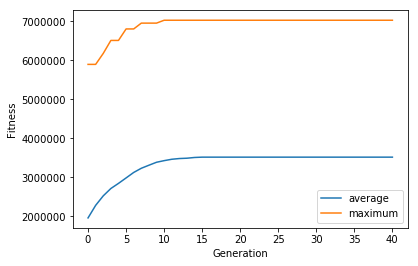

In [72]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

#print ('Evaluation of best individual:', parse_scholarships(hof[0]))
print ('Bucket, Students, ScholarshipUsed, NetRevenue, AvgTestScore, Yield')
print ('Evaluation of best individual detailed:', parse_scholarships_base((hof[0]), True))

import matplotlib.pyplot as plt
gen, avg, max_ = logbook.select("gen", "avg", "max")
plt.plot(gen, avg, label="average")
plt.plot(gen, max_, label="maximum")
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.legend(loc="lower right")
plt.show()

In [77]:
bucket_list = [1000, 1000, 1000, 1000, 1000, 1000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 3500, 4500, 5500, 8000, 8000, 9000]
bucket_list = [0, 0, 0, 0, 0, 0, 0, 3000, 3000, 3000, 3000, 3000, 3000, 3000, 4000, 5000, 5000, 6000, 6000, 9000]
bucket_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4000, 4000, 4000, 4000, 6000, 6000, 8000, 8000, 9000]
bucket_list = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6000, 7000, 8000, 9000, 11000]
parse_scholarships_base(bucket_list, True)

Bucket: 0; students: 23; scholarships: 0; gross: 785289; test score: 955.0; student %age: 0.031377899045
Bucket: 1; students: 16; scholarships: 0; gross: 546288; test score: 1001.875; student %age: 0.021768707483
Bucket: 2; students: 23; scholarships: 0; gross: 785289; test score: 1245.86956522; student %age: 0.031377899045
Bucket: 3; students: 28; scholarships: 0; gross: 956004; test score: 1270.35714286; student %age: 0.0381991814461
Bucket: 4; students: 63; scholarships: 0; gross: 2151009; test score: 1285.79365079; student %age: 0.0854816824966
Bucket: 5; students: 50; scholarships: 0; gross: 1707150; test score: 1334.7; student %age: 0.068306010929
Bucket: 6; students: 78; scholarships: 0; gross: 2663154; test score: 1320.12820513; student %age: 0.106412005457
Bucket: 7; students: 59; scholarships: 0; gross: 2014437; test score: 1291.69491525; student %age: 0.0801630434783
Bucket: 8; students: 45; scholarships: 0; gross: 1536435; test score: 1239.11111111; student %age: 0.06155950

(87036733.24188131, 30316000L, 4356, 1410.376492194674, 0.29640718562874252)